In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



In [3]:
df = pd.read_csv('../../data/downloads/cleaned_20250429_140234.csv')
df

c:\Users\nzhuw\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,site,site_description,supplier_no,supplier_name,invoice_id,invoice_no,date_posted,project_id,project_name,account,...,multiple_commodities,priority_multiple_commodities,all_invoice_priority_products_2008,any_invoice_priority_products_2008,freight_per_invoice,priority_product_total,non_priority_product_total,percentage_priority,percentage_non_priority,pct_priority_greater_than_70
0,SPN,Spectra Norcross,103277,William M. Bird,531030,656881,01-Mar-24,2401132763,FAROPOINT LOBBY RENOVATION,2008,...,False,False,True,True,5.79,1343.25,0.00,100.000000,0.000000,True
1,SPN,Spectra Norcross,103423,"Shaw Industries, Inc.",561080,9550085,20-Mar-24,2401132815,PCI-SCU Griffin Carpet Replacement,2008,...,False,False,True,True,2.02,1749.32,0.00,100.000000,0.000000,True
2,SPT,Spectra Tampa,107776,J.J. Haines & Company,453368,199901,17-Jan-24,2310117701,IMP Suite 116,2008,...,False,False,True,True,2.23,111.98,0.00,100.000000,0.000000,True
3,SPW,Spectra Longwood,121550,Mohawk Industries,1260023,C4169885,12-Dec-24,2406163665,PSG Seminole Sports Med - 5300 W SR,2008,...,False,False,True,True,55.71,5745.60,0.00,100.000000,0.000000,True
4,BNB,Beckers New Brighton,104716,Hank's Specialties,433340,173373,03-Jan-24,2312127706,UOFM MOLECULAR & CELLULAR BIOLOGY P,2008,...,True,False,False,True,50.00,715.20,871.88,45.063891,54.936109,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88710,SPWV,Spectra W Valley Cty,121550,Mohawk Industries,1749432,9500882374,25-Mar-25,2412198745,South Town Mall - Forever Young Sto,2008,...,True,False,False,True,3273.70,22581.46,2376.00,90.479800,9.520200,True
88711,SPWV,Spectra W Valley Cty,121550,Mohawk Industries,1749432,9500882374,25-Mar-25,2412198745,South Town Mall - Forever Young Sto,2008,...,True,False,False,True,3273.70,22581.46,2376.00,90.479800,9.520200,True
88712,SPWV,Spectra W Valley Cty,121550,Mohawk Industries,1749432,9500882374,25-Mar-25,2412198745,South Town Mall - Forever Young Sto,2008,...,True,False,False,True,3273.70,22581.46,2376.00,90.479800,9.520200,True
88713,SPWV,Spectra W Valley Cty,121550,Mohawk Industries,1749432,9500882374,25-Mar-25,2412198745,South Town Mall - Forever Young Sto,2008,...,True,False,False,True,3273.70,22581.46,2376.00,90.479800,9.520200,True


In [4]:
df = df.drop_duplicates(subset='invoice_id', keep='first')
df

,site,site_description,supplier_no,supplier_name,invoice_id,invoice_no,date_posted,project_id,project_name,account,...,multiple_commodities,priority_multiple_commodities,all_invoice_priority_products_2008,any_invoice_priority_products_2008,freight_per_invoice,priority_product_total,non_priority_product_total,percentage_priority,percentage_non_priority,pct_priority_greater_than_70
0,SPN,Spectra Norcross,103277,William M. Bird,531030,656881,01-Mar-24,2401132763,FAROPOINT LOBBY RENOVATION,2008,...,False,False,True,True,5.79,1343.25,0.00,100.000000,0.000000,True
1,SPN,Spectra Norcross,103423,"Shaw Industries, Inc.",561080,9550085,20-Mar-24,2401132815,PCI-SCU Griffin Carpet Replacement,2008,...,False,False,True,True,2.02,1749.32,0.00,100.000000,0.000000,True
2,SPT,Spectra Tampa,107776,J.J. Haines & Company,453368,199901,17-Jan-24,2310117701,IMP Suite 116,2008,...,False,False,True,True,2.23,111.98,0.00,100.000000,0.000000,True
3,SPW,Spectra Longwood,121550,Mohawk Industries,1260023,C4169885,12-Dec-24,2406163665,PSG Seminole Sports Med - 5300 W SR,2008,...,False,False,True,True,55.71,5745.60,0.00,100.000000,0.000000,True
4,BNB,Beckers New Brighton,104716,Hank's Specialties,433340,173373,03-Jan-24,2312127706,UOFM MOLECULAR & CELLULAR BIOLOGY P,2008,...,True,False,False,True,50.00,715.20,871.88,45.063891,54.936109,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88699,SPWV,Spectra W Valley Cty,121550,Mohawk Industries,1749922,9500598166,24-Mar-25,2410188195,Natures Bakery,2008,...,True,False,False,True,125.00,4888.08,2376.00,67.291109,32.708891,False
88701,SPWV,Spectra W Valley Cty,103423,"Shaw Industries, Inc.",1750408,5318191,25-Mar-25,2503217190,Revere Health AF Nephrology Suite 1,2008,...,False,False,True,True,80.37,692.40,0.00,100.000000,0.000000,True
88702,SPWV,Spectra W Valley Cty,103423,"Shaw Industries, Inc.",1750407,5318192,25-Mar-25,2311123133,FIRECLAY APARTMENTS,2008,...,False,False,True,True,128.48,791.85,0.00,100.000000,0.000000,True
88703,SPWV,Spectra W Valley Cty,107786,Dal Tile Corporation,1750575,144922335,25-Mar-25,230692391,Valo Townhomes,2008,...,True,NaN,False,False,14.92,0.00,745.98,0.000000,100.000000,False


In [5]:
df.columns

Index(['site', 'site_description', 'supplier_no', 'supplier_name',
       'invoice_id', 'invoice_no', 'date_posted', 'project_id', 'project_name',
       'account', 'account_description', 'planned_delivery_date',
       'ship_to_zip', 'po_no', 'po_line_no', 'po_rel_no', 'receipt_no',
       'part_no', 'part_description', 'comm_1', 'comm_2', 'po_purch_qty',
       'purch_uom', 'po_inv_qty', 'inv_uom', 'invoiced_line_qty',
       'invoice_line_total', 'po_price', 'commodity_group', 'description',
       'old/new', 'priority', 'match_commodity', 'match_supplier',
       'is_classified', 'line_classification', 'new_commodity_description',
       'new_commodity_group', 'conversion_code', 'invoice_priority_classified',
       'invoice_priority_conversion_success', 'has_freight_line',
       'multiple_freight_lines', 'multiple_parts', 'multiple_commodities',
       'priority_multiple_commodities', 'all_invoice_priority_products_2008',
       'any_invoice_priority_products_2008', 'freight_per_

IndexError: index 3 is out of bounds for axis 1 with size 3

c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128200 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128200 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0, flags=flags)


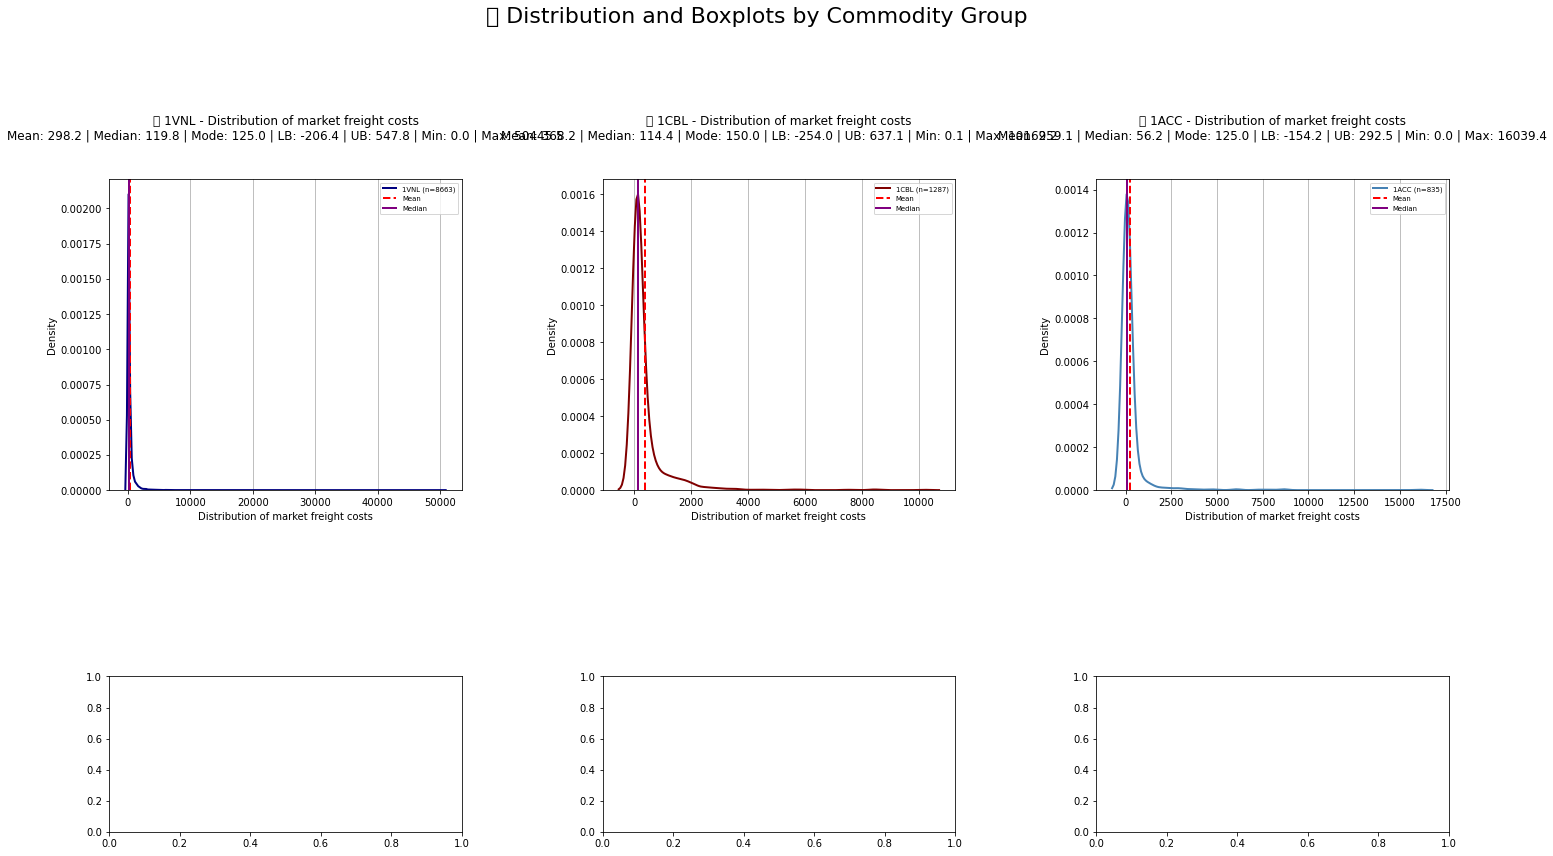

In [9]:

# Remove infinities
df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)

# 📊 Define metrics
metric = "freight_per_invoice"
title = "Distribution of market freight costs"
colors = ["navy", "maroon", "steelblue"]

# 🔁 Get unique commodity groups
commodity_groups = df['new_commodity_group'].dropna().unique()

# 🎨 Assign color palette per commodity group
commodity_palette = dict(zip(commodity_groups, colors))

# Setup single figure with 3 columns
fig, axes = plt.subplots(2, 3, figsize=(24, 12), gridspec_kw={'height_ratios': [2, 1]})
fig.subplots_adjust(hspace=0.8, wspace=0.4)
fig.suptitle(f"📦 Distribution and Boxplots by Commodity Group", fontsize=22, y=1.08)

# 📈 Top Row: KDE Plots
for idx, group in enumerate(commodity_groups):
    group_df = df[df['new_commodity_group'] == group]
    data = group_df[metric].dropna()

    ax_top = axes[0, idx]
    if len(data) > 1:
        sns.kdeplot(
            data,
            ax=ax_top,
            label=f"{group} (n={group_df['invoice_id'].nunique()})",
            color=commodity_palette.get(group, "gray"),
            linewidth=2
        )

        # 📌 Calculate key stats
        q1 = data.quantile(0.25)
        median = data.median()
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        mean = data.mean()
        mode = data.mode().iloc[0] if not data.mode().empty else None
        minimum = data.min()
        maximum = data.max()

        # 📏 Only plot mean and median vertical lines
        ax_top.axvline(mean, color='red', linestyle='--', linewidth=2, label='Mean')
        ax_top.axvline(median, color='purple', linestyle='-', linewidth=2, label='Median')

        # 📝 Add summary text ABOVE the title
        stats_text = (
            f"Mean: {mean:.1f} | Median: {median:.1f} | Mode: {mode:.1f} | "
            f"LB: {lower_bound:.1f} | UB: {upper_bound:.1f} | "
            f"Min: {minimum:.1f} | Max: {maximum:.1f}"
        )
        ax_top.set_title(
            f"📈 {group} - {title}\n{stats_text}",
            fontsize=12,
            pad=40
        )

    else:
        ax_top.set_title(f"{group} - No data", fontsize=14)

    ax_top.set_xlabel(title)
    ax_top.set_ylabel("Density")
    ax_top.grid(axis='y', visible=False)
    ax_top.grid(axis='x', visible=True)
    ax_top.legend(fontsize="x-small", loc='upper right')



plt.tight_layout()
plt.show()


In [10]:
df.columns

Index(['site', 'site_description', 'supplier_no', 'supplier_name',
       'invoice_id', 'invoice_no', 'date_posted', 'project_id', 'project_name',
       'account', 'account_description', 'planned_delivery_date',
       'ship_to_zip', 'po_no', 'po_line_no', 'po_rel_no', 'receipt_no',
       'part_no', 'part_description', 'comm_1', 'comm_2', 'po_purch_qty',
       'purch_uom', 'po_inv_qty', 'inv_uom', 'invoiced_line_qty',
       'invoice_line_total', 'po_price', 'commodity_group', 'description',
       'old/new', 'priority', 'match_commodity', 'match_supplier',
       'is_classified', 'line_classification', 'new_commodity_description',
       'new_commodity_group', 'conversion_code', 'invoice_priority_classified',
       'invoice_priority_conversion_success', 'has_freight_line',
       'multiple_freight_lines', 'multiple_parts', 'multiple_commodities',
       'priority_multiple_commodities', 'all_invoice_priority_products_2008',
       'any_invoice_priority_products_2008', 'freight_per_

In [ ]:

# Remove infinities
df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)

# 📊 Define metrics
metric = "freight_per_invoice"
title = "Distribution of market freight costs"
colors = ["navy", "maroon", "steelblue"]

# 🔁 Get unique commodity groups
commodity_groups = df['new_commodity_group'].dropna().unique()

# 🎨 Assign color palette per commodity group
commodity_palette = dict(zip(commodity_groups, colors))

# Setup single figure with 3 columns
fig, axes = plt.subplots(2, 3, figsize=(24, 12), gridspec_kw={'height_ratios': [2, 1]})
fig.subplots_adjust(hspace=0.8, wspace=0.4)
fig.suptitle(f"📦 Distribution and Boxplots by Commodity Group", fontsize=22, y=1.08)

# 📈 Top Row: KDE Plots
for idx, group in enumerate(commodity_groups):
    group_df = df[df['new_commodity_group'] == group]
    data = group_df[metric].dropna()

    ax_top = axes[0, idx]
    if len(data) > 1:
        sns.kdeplot(
            data,
            ax=ax_top,
            label=f"{group} (n={group_df['invoice_id'].nunique()})",
            color=commodity_palette.get(group, "gray"),
            linewidth=2
        )

        # 📌 Calculate key stats
        q1 = data.quantile(0.25)
        median = data.median()
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        mean = data.mean()
        mode = data.mode().iloc[0] if not data.mode().empty else None
        minimum = data.min()
        maximum = data.max()

        # 📏 Only plot mean and median vertical lines
        ax_top.axvline(mean, color='red', linestyle='--', linewidth=2, label='Mean')
        ax_top.axvline(median, color='purple', linestyle='-', linewidth=2, label='Median')

        # 📝 Add summary text ABOVE the title
        stats_text = (
            f"Mean: {mean:.1f} | Median: {median:.1f} | Mode: {mode:.1f} | "
            f"LB: {lower_bound:.1f} | UB: {upper_bound:.1f} | "
            f"Min: {minimum:.1f} | Max: {maximum:.1f}"
        )
        ax_top.set_title(
            f"📈 {group} - {title}\n{stats_text}",
            fontsize=12,
            pad=40
        )

    else:
        ax_top.set_title(f"{group} - No data", fontsize=14)

    ax_top.set_xlabel(title)
    ax_top.set_ylabel("Density")
    ax_top.grid(axis='y', visible=False)
    ax_top.grid(axis='x', visible=True)
    ax_top.legend(fontsize="x-small", loc='upper right')



plt.tight_layout()
plt.show()
